Notebook usado para analizar en un pequeño ejemplo de datos como se distribuyen los tags creados, como son los datos numéricos, como correlacionan los datos entre ellos. (Se ha hecho con una sola compañía para aligerar el proceso. Tras esto suponemos que cuando tengamos el resto de datos para las demás compañías, aunque no de la misma manera, pero se comporte parecido, es decir, que el mejor modelo sea el mismo, y que las variables correlacionen de la misma manera o muy parecida).

Además en este notebook está todo el trabajo de comprobar que modelo de datos es el más adecuado para el problema de predecir, el modelo de datos usado finalmente será (Robust Scaler + Random Forest sin outliers).

In [3]:
import sys
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier

sns.set()
warnings.filterwarnings("ignore")

app_path = '/Users/esanc147/Documents/business/bsm03/web_app'
if app_path in sys.path:
    from tools.tags import create_tags
else: 
    sys.path.append('/Users/esanc147/Documents/business/bsm03/web_app')
    from tools.tags import create_tags
    
    

In [54]:
COLUMNS_TECH = ['symbol', 'date', 'MACD_Signal', 'MACD_Hist', 'MACD', 'SlowK', 'SlowD',
       'Chaikin A/D', 'OBV', 'EMA21', 'SMA21', 'WMA21', 'RSI21', 'ADX21',
       'CCI21', 'Aroon Up21', 'Aroon Down21', 'Real Lower Band21',
       'Real Upper Band21', 'Real Middle Band21', 'EMA28', 'SMA28', 'WMA28',
       'RSI28', 'ADX28', 'CCI28', 'Aroon Down28', 'Aroon Up28',
       'Real Lower Band28', 'Real Upper Band28', 'Real Middle Band28', 'EMA50',
       'SMA50', 'WMA50', 'RSI50', 'ADX50', 'CCI50', 'Aroon Up50',
       'Aroon Down50', 'Real Middle Band50', 'Real Lower Band50',
       'Real Upper Band50']
COLUMNS = ['symbol', 'date', 'close', 'volume', 'open', 'high', 'low']
U_COLUMNS = ['close', 'volume', 'MACD_Signal', 'MACD_Hist', 'MACD', 'SlowK', 'SlowD', 
             'Chaikin A/D', 'OBV', 'RSI21', 'ADX21', 'CCI21', 'Aroon Up21', 'Aroon Down21', 
             'RSI28', 'ADX28', 'CCI28', 'Aroon Down28', 'Aroon Up28', 'Real Lower Band28', 
             'Real Upper Band28', 'Real Middle Band28', 'SMA50', 'RSI50', 'ADX50', 'CCI50', 
             'Aroon Up50', 'Aroon Down50']
COLS_WO_FIN = ['close', 'volume', 'MACD_Signal', 'MACD_Hist',
       'MACD', 'SlowK', 'SlowD', 'Chaikin A/D', 'OBV', 'EMA21', 'SMA21',
       'WMA21', 'RSI21', 'ADX21', 'CCI21', 'Aroon Up21', 'Aroon Down21',
       'Real Lower Band21', 'Real Upper Band21', 'Real Middle Band21', 'EMA28',
       'SMA28', 'WMA28', 'RSI28', 'ADX28', 'CCI28', 'Aroon Down28',
       'Aroon Up28', 'Real Lower Band28', 'Real Upper Band28',
       'Real Middle Band28', 'EMA50', 'SMA50', 'WMA50', 'RSI50', 'ADX50',
       'CCI50', 'Aroon Up50', 'Aroon Down50', 'Real Middle Band50',
       'Real Lower Band50', 'Real Upper Band50']
SYMBOLS = ['AAPL', 'MSFT', 'AMZN']
FULL_PATH = "/Users/esanc147/Documents/business/bsm03/web_app/data"

In [5]:
symbol = SYMBOLS[2]

path_close = f"{FULL_PATH}/close/{symbol}.csv"
df_close = pd.read_csv(path_close, names=COLUMNS)
df_close['date'] = pd.to_datetime(df_close['date'])
df_close['volume'] = df_close['volume'].astype(float)

path_tech = f"{FULL_PATH}/tech/{symbol}.csv"
df_tech = pd.read_csv(path_tech, names=COLUMNS_TECH)
df_tech['date'] = pd.to_datetime(df_tech['date'])

list_df_tagged = []
for period in [7, 14, 21, 28]:
    df_aux = create_tags(df_close, period)
    df_aux[f"pct_change_{period}"] = df_aux[f"pct_change_{period}"].astype(float)
    df_aux[f"pct_change_{period}"] = df_aux[f"pct_change_{period}"].astype(float)
    list_df_tagged.append(df_aux)
df_tagged = pd.concat(list_df_tagged, axis=1)
df_tagged.dropna(inplace=True)

df_close = df_close.set_index(['symbol', 'date'])
df_tech = df_tech.set_index(['symbol', 'date'])
dataframe = pd.concat([df_close, df_tech, df_tagged], join='inner', axis=1)

### Tamaño del dataframe

In [6]:
dataframe.shape

(3526, 53)

### Comprobar si alguna columna tiene nulos

In [7]:
dataframe.isnull().any().any()

False

### Límites de fechas que tenemos

In [8]:
dataframe.index.min()

('AMZN', Timestamp('2006-04-26 00:00:00'))

In [9]:
dataframe.index.max()

('AMZN', Timestamp('2020-04-28 00:00:00'))

### Tipos de datos que tenemos en el dataframe

In [10]:
dataframe.dtypes.value_counts()

float64    49
object      4
dtype: int64

### Como se distribuyen los datos de tagging

Porcentaje de subida: 50.77% | Porcentaje de bajada: 38.32%


bull            28.332388
strong bear     23.596143
strong bull     20.334657
bear            12.195122
keep            10.918888
outlier bear     2.524107
outlier bull     2.098695
Name: tag_7, dtype: float64

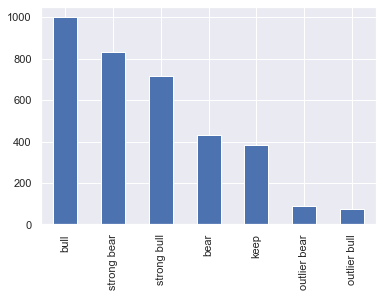

In [11]:
dataframe.select_dtypes(object)['tag_7'].value_counts().plot.bar();
norm = dataframe.select_dtypes(object)['tag_7'].value_counts(normalize=True) * 100
print(f"Porcentaje de subida: {round(norm[norm.index.str.endswith('bull')].sum(), 2)}% | Porcentaje de bajada: {round(norm[norm.index.str.endswith('bear')].sum(), 2)}%")
norm

Porcentaje de subida: 54.42% | Porcentaje de bajada: 34.34%


bull            29.211571
strong bull     23.312535
strong bear     21.100397
keep            11.230856
bear            10.692002
outlier bear     2.552467
outlier bull     1.900170
Name: tag_14, dtype: float64

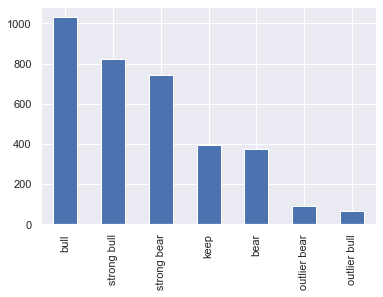

In [12]:
dataframe.select_dtypes(object)['tag_14'].value_counts().plot.bar();
norm = dataframe.select_dtypes(object)['tag_14'].value_counts(normalize=True) * 100
print(f"Porcentaje de subida: {round(norm[norm.index.str.endswith('bull')].sum(), 2)}% | Porcentaje de bajada: {round(norm[norm.index.str.endswith('bear')].sum(), 2)}%")
norm

Porcentaje de subida: 56.44% | Porcentaje de bajada: 31.96%


bull            30.657969
strong bull     23.936472
strong bear     19.483834
keep            11.599546
bear            10.465116
outlier bear     2.013613
outlier bull     1.843449
Name: tag_21, dtype: float64

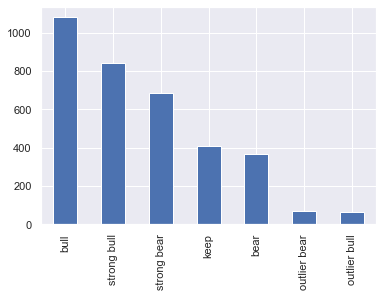

In [13]:
dataframe.select_dtypes(object)['tag_21'].value_counts().plot.bar();
norm = dataframe.select_dtypes(object)['tag_21'].value_counts(normalize=True) * 100
print(f"Porcentaje de subida: {round(norm[norm.index.str.endswith('bull')].sum(), 2)}% | Porcentaje de bajada: {round(norm[norm.index.str.endswith('bear')].sum(), 2)}%")
norm

Porcentaje de subida: 58.05% | Porcentaje de bajada: 30.2%


bull            31.480431
strong bull     24.503687
strong bear     18.377765
keep            11.741350
bear             9.841180
outlier bull     2.070335
outlier bear     1.985252
Name: tag_28, dtype: float64

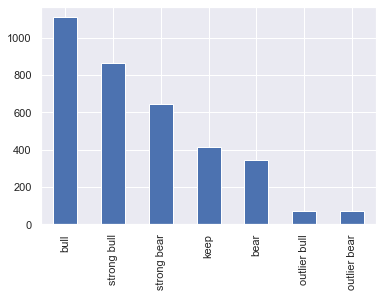

In [14]:
dataframe.select_dtypes(object)['tag_28'].value_counts().plot.bar();
norm = dataframe.select_dtypes(object)['tag_28'].value_counts(normalize=True) * 100
print(f"Porcentaje de subida: {round(norm[norm.index.str.endswith('bull')].sum(), 2)}% | Porcentaje de bajada: {round(norm[norm.index.str.endswith('bear')].sum(), 2)}%")
norm

### Como se distribuyen los datos numéricos

In [15]:
pd.set_option('display.max_columns', 30)
dataframe.select_dtypes(float)[U_COLUMNS].describe()

,close,volume,MACD_Signal,MACD_Hist,MACD,SlowK,SlowD,Chaikin A/D,OBV,RSI21,ADX21,CCI21,Aroon Up21,Aroon Down21,RSI28,ADX28,CCI28,Aroon Down28,Aroon Up28,Real Lower Band28,Real Upper Band28,Real Middle Band28,SMA50,RSI50,ADX50,CCI50,Aroon Up50,Aroon Down50
count,3526.000000,3.526000e+03,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3.526000e+03,3.526000e+03,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000,3526.000000
mean,546.173280,5.729599e+06,3.961858,0.125156,4.087014,55.746981,55.741896,1.334618e+09,7.324821e+08,54.703267,21.558566,28.805406,58.975504,40.955620,54.559871,19.176003,32.604216,40.156794,60.002229,499.269401,576.288324,537.778862,531.840424,54.279891,15.059459,42.432129,62.136132,37.248440
std,601.931181,4.728222e+06,14.179296,5.204399,15.737184,25.046979,23.113039,4.150521e+08,2.508442e+08,9.892523,7.711861,111.241472,35.255237,34.869311,8.651192,6.903640,112.676179,34.580915,34.780126,552.366660,634.424429,592.674877,587.588039,6.605656,5.587586,112.222272,33.991299,33.851257
min,26.070000,8.813370e+05,-67.632300,-36.030400,-82.597600,1.843300,5.715500,3.172084e+08,1.329609e+08,27.625400,7.679100,-424.391600,0.000000,0.000000,30.835000,7.314500,-435.619500,0.000000,0.000000,22.403900,30.833000,27.784600,29.450000,35.939800,6.641600,-369.671800,0.000000,0.000000
25%,108.742500,3.117449e+06,-0.913100,-1.032450,-1.009775,34.615175,36.102075,1.030024e+09,5.387952e+08,47.419900,16.051625,-60.675350,24.999975,9.523800,48.151950,14.448075,-55.912400,7.142900,28.571400,85.056525,105.766725,94.075925,89.355550,49.366050,11.312100,-36.857575,32.000000,6.000000
50%,268.880000,4.609650e+06,1.882400,-0.014750,1.921850,56.855350,56.945550,1.483599e+09,7.183450e+08,54.844050,20.110100,46.568200,66.666700,33.333300,54.539150,17.707950,50.561300,32.142900,67.857100,252.715750,278.314500,265.793150,264.531100,54.008750,13.914950,58.904900,72.000000,26.000000
75%,771.372500,6.872125e+06,6.474275,1.165025,6.684775,78.214200,76.121775,1.639126e+09,9.225136e+08,61.544875,25.698950,108.173250,90.476200,71.428600,60.557125,22.726675,111.963000,71.428600,92.857100,738.489150,797.938400,768.661875,772.699000,58.950900,17.275650,118.577700,94.000000,66.000000
max,2410.220000,1.043292e+08,110.027900,51.017500,128.593000,99.937000,97.256900,1.863836e+09,1.201858e+09,90.269600,57.792500,508.265400,100.000000,100.000000,86.580800,51.448900,541.574700,100.000000,100.000000,1896.838500,2530.955800,2113.612500,2029.031200,77.953100,38.795500,674.831800,100.000000,100.000000


### Mapa de calor de la correlación de las variables

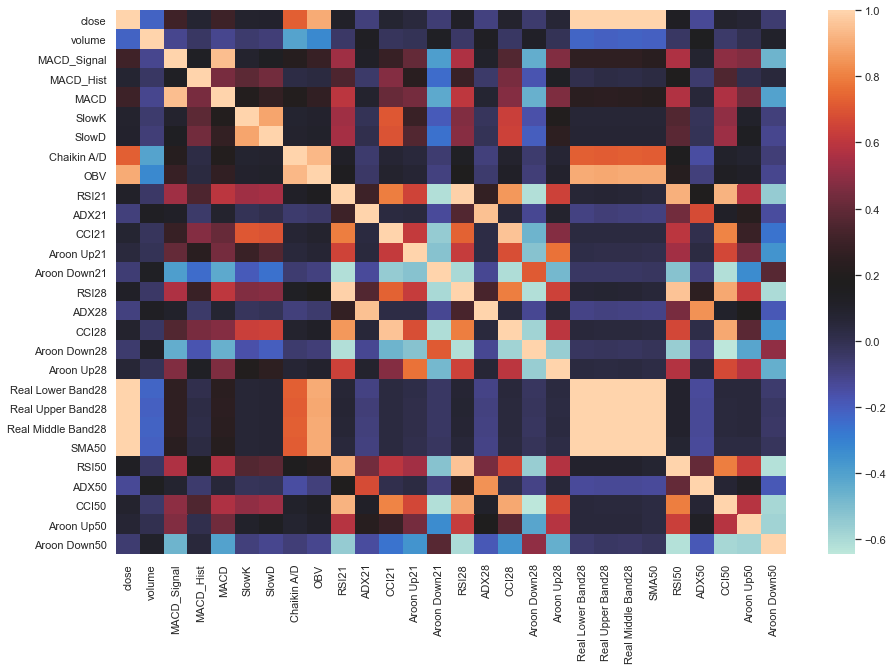

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(dataframe[U_COLUMNS].corr(), 
            xticklabels=True, yticklabels=True, 
            cmap="icefire");

### Función creada por usuario RobustScaler

In [17]:
@nb.jit(nopython=False)
def ud_robust_scaler(data, columns, rel_delta):
    row = 0
    arr_sd = data[:, 0:2]
    result = np.zeros((data.shape[0], len(columns[2:])))
    for date in data[:, 1]:
        # Filtrado de los ultimos 4 meses a fecha dada
        datetime_ = datetime(date.year, date.month, date.day)
        arr_aux = data[(data[:, 1] >= datetime_-rel_delta) \
                       & (data[:, 1] <= datetime_)][:, 2:]
        if arr_aux.shape[0] <= 70:
            break
        for col in range(len(columns[2:])):
            p25 = np.percentile(arr_aux[:, col], 25)
            p75 = np.percentile(arr_aux[:, col], 75)
            p50 = np.percentile(arr_aux[:, col], 50)
            iqr = p75 - p25
            result[row, col] = (arr_aux[0, col] - p50) / iqr
            
        row += 1
        
    return result

### KNN

In [18]:
dataframe_reset = dataframe.reset_index()
dataframe_train = dataframe_reset[dataframe_reset['date'].dt.year <= 2017] \
                    .sort_values(by='date', ascending=False) \
                    .set_index(['symbol', 'date'])
                    
dataframe_test = dataframe_reset[(dataframe_reset['date'].dt.year > 2017)
                                 & (dataframe_reset['date'].dt.year < 2019)] \
                    .sort_values(by='date', ascending=False) \
                    .set_index(['symbol', 'date'])

#### KNN - Todos los datos | UDF | Con outliers

In [19]:
knn = KNeighborsClassifier(weights='distance')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(list(df_aux.select_dtypes(float).columns))
df_aux = df_aux[cols]
X_train = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_train = dataframe_train['tag_28'].values

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(list(df_aux.select_dtypes(float).columns))
df_aux = df_aux[cols]
X_test = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_test = dataframe_test['tag_28'].values

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.08      0.39      0.13        18
        bull       0.54      0.38      0.44        98
        keep       0.30      0.15      0.20        39
outlier bear       0.14      1.00      0.25         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.45      0.27      0.33        49
 strong bull       0.34      0.27      0.30        44

    accuracy                           0.30       251
   macro avg       0.26      0.35      0.24       251
weighted avg       0.41      0.30      0.33       251



#### KNN - Todos los datos | Sin escalado | Con outliers

In [20]:
knn = KNeighborsClassifier(weights='distance')

In [21]:
X_train = dataframe_train.select_dtypes(float).values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float).values
y_test = dataframe_test['tag_28'].values

In [22]:
knn.fit(X_train, y_train);

In [23]:
y_pred = knn.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.78      0.59      0.67        49
 strong bull       0.21      1.00      0.34        44

    accuracy                           0.29       251
   macro avg       0.14      0.23      0.15       251
weighted avg       0.19      0.29      0.19       251



#### KNN - COLS_WO_FIN | Sin escalado | Con outliers

In [31]:
knn = KNeighborsClassifier(weights='distance')

In [32]:
X_train = dataframe_train.select_dtypes(float)[COLS_WO_FIN].values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
y_test = dataframe_test['tag_28'].values

In [33]:
knn.fit(X_train, y_train);

In [34]:
y_pred = knn.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.78      0.59      0.67        49
 strong bull       0.21      1.00      0.34        44

    accuracy                           0.29       251
   macro avg       0.14      0.23      0.15       251
weighted avg       0.19      0.29      0.19       251



#### KNN - U_COLUMNS | Sin escalado | Con outliers

In [36]:
knn = KNeighborsClassifier(weights='distance')

In [37]:
X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values

In [38]:
knn.fit(X_train, y_train);

In [39]:
y_pred = knn.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.78      0.59      0.67        49
 strong bull       0.21      1.00      0.34        44

    accuracy                           0.29       251
   macro avg       0.14      0.23      0.15       251
weighted avg       0.19      0.29      0.19       251



#### KNN - U_COLUMNS | UDF | Con outliers

In [41]:
knn = KNeighborsClassifier(weights='distance')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_train = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_train = dataframe_train['tag_28'].values

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_test = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_test = dataframe_test['tag_28'].values

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.10      0.11      0.11        18
        bull       0.38      0.26      0.30        98
        keep       0.11      0.05      0.07        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.21      0.14      0.17        49
 strong bull       0.26      0.25      0.26        44

    accuracy                           0.19       251
   macro avg       0.15      0.12      0.13       251
weighted avg       0.26      0.19      0.22       251



#### KNN - Todos los datos | Sin escalado | Sin outliers

In [42]:
knn = KNeighborsClassifier(weights='distance')

In [43]:
X_train = dataframe_train.select_dtypes(float).values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float).values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [44]:
# X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
#             .select_dtypes(float).values
# y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

# X_test = dataframe_test.select_dtypes(float).values
# y_test = dataframe_test['tag_28'].values
# y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
# y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [45]:
knn.fit(X_train, y_train);

In [46]:
y_pred = knn.predict(X_test)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
 strong bear       0.78      0.58      0.67        50
 strong bull       0.21      1.00      0.35        46

    accuracy                           0.30       251
   macro avg       0.20      0.32      0.20       251
weighted avg       0.20      0.30      0.20       251



#### KNN - COLS_WO_FIN | Sin escalado | Sin outliers

In [55]:
knn = KNeighborsClassifier(weights='distance')

In [56]:
X_train = dataframe_train.select_dtypes(float)[COLS_WO_FIN].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [57]:
# X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
#             .select_dtypes(float)[COLS_WO_FIN].values
# y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

# X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
# y_test = dataframe_test['tag_28'].values
# y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
# y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [58]:
knn.fit(X_train, y_train);

In [59]:
y_pred = knn.predict(X_test)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
 strong bear       0.78      0.58      0.67        50
 strong bull       0.21      1.00      0.35        46

    accuracy                           0.30       251
   macro avg       0.20      0.32      0.20       251
weighted avg       0.20      0.30      0.20       251



#### KNN - U_COLUMNS | Sin escalado | Sin outliers

In [61]:
knn = KNeighborsClassifier(weights='distance')

X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [62]:
knn.fit(X_train, y_train);

In [63]:
y_pred = knn.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
 strong bear       0.78      0.58      0.67        50
 strong bull       0.21      1.00      0.35        46

    accuracy                           0.30       251
   macro avg       0.20      0.32      0.20       251
weighted avg       0.20      0.30      0.20       251



In [65]:
knn = KNeighborsClassifier(weights='distance')

X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
            .select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [66]:
knn.fit(X_train, y_train);

In [67]:
y_pred = knn.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.00      0.00      0.00        98
        keep       0.00      0.00      0.00        39
 strong bear       0.78      0.58      0.67        50
 strong bull       0.21      1.00      0.35        46

    accuracy                           0.30       251
   macro avg       0.20      0.32      0.20       251
weighted avg       0.20      0.30      0.20       251



#### KNN - U_COLUMNS | Robust Scaler | Con outliers

In [69]:
knn = KNeighborsClassifier(weights='distance')
scl = RobustScaler()

In [70]:
X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
X_scl_train = scl.fit_transform(X_train)
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
X_scl_test = scl.transform(X_test)
y_test = dataframe_test['tag_28'].values

In [71]:
knn.fit(X_scl_train, y_train);

In [72]:
y_pred = knn.predict(X_scl_test)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.40      0.62      0.49        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.00      0.00      0.00        49
 strong bull       0.18      0.32      0.23        44

    accuracy                           0.30       251
   macro avg       0.08      0.13      0.10       251
weighted avg       0.19      0.30      0.23       251



#### KNN - U_COLUMNS | Robust Scaler | Sin outliers

In [74]:
knn = KNeighborsClassifier(weights='distance')
scl = RobustScaler()

X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)
X_scl_train = scl.fit_transform(X_train)

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)
X_scl_test = scl.transform(X_test)

In [75]:
knn.fit(X_scl_train, y_train);

In [76]:
y_pred = knn.predict(X_scl_test)

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.40      0.62      0.49        98
        keep       0.00      0.00      0.00        39
 strong bear       0.00      0.00      0.00        50
 strong bull       0.21      0.35      0.26        46

    accuracy                           0.31       251
   macro avg       0.12      0.19      0.15       251
weighted avg       0.20      0.31      0.24       251



In [78]:
knn = KNeighborsClassifier(weights='distance')
scl = RobustScaler()

X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
            .select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values
X_scl_train = scl.fit_transform(X_train)
X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)
X_scl_test = scl.transform(X_test)

In [79]:
knn.fit(X_scl_train, y_train);

In [80]:
y_pred = knn.predict(X_scl_test)

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.40      0.62      0.49        98
        keep       0.00      0.00      0.00        39
 strong bear       0.00      0.00      0.00        50
 strong bull       0.22      0.35      0.27        46

    accuracy                           0.31       251
   macro avg       0.12      0.19      0.15       251
weighted avg       0.20      0.31      0.24       251



### Random Forest

In [82]:
dataframe_reset = dataframe.reset_index()
dataframe_train = dataframe_reset[dataframe_reset['date'].dt.year <= 2017].set_index(['symbol', 'date'])
dataframe_test = dataframe_reset[(dataframe_reset['date'].dt.year > 2017)
                                 & (dataframe_reset['date'].dt.year < 2019)].set_index(['symbol', 'date'])

#### Random Forest - Todos los datos | Sin escalado | Con outliers

In [83]:
clf = RandomForestClassifier(criterion='entropy')

In [84]:
X_train = dataframe_train.select_dtypes(float).values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float).values
y_test = dataframe_test['tag_28'].values

In [85]:
clf.fit(X_train, y_train);

In [86]:
y_pred = clf.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.32      0.44      0.37        18
        bull       0.64      0.81      0.71        98
        keep       0.88      0.18      0.30        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.74      0.82      0.78        49
 strong bull       0.46      0.43      0.45        44

    accuracy                           0.61       251
   macro avg       0.43      0.38      0.37       251
weighted avg       0.64      0.61      0.58       251



#### Random Forest - COLS_WO_FIN | Sin escalado | Con outliers

In [88]:
clf = RandomForestClassifier(criterion='entropy')

In [89]:
X_train = dataframe_train.select_dtypes(float)[COLS_WO_FIN].values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
y_test = dataframe_test['tag_28'].values

In [90]:
clf.fit(X_train, y_train);

In [91]:
y_pred = clf.predict(X_test)

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.31      0.52      0.39        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.08      0.02      0.03        49
 strong bull       0.25      0.32      0.28        44

    accuracy                           0.26       251
   macro avg       0.09      0.12      0.10       251
weighted avg       0.18      0.26      0.21       251



#### Random Forest - U_COLUMNS | Sin escalado | Con outliers

In [161]:
clf = RandomForestClassifier(criterion='entropy')

In [162]:
X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values

In [163]:
clf.fit(X_train, y_train);

In [164]:
y_pred = clf.predict(X_test)

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.37      0.58      0.45        98
        keep       0.20      0.03      0.05        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.31      0.10      0.15        49
 strong bull       0.35      0.45      0.40        44

    accuracy                           0.33       251
   macro avg       0.18      0.17      0.15       251
weighted avg       0.30      0.33      0.28       251



#### Random Forest - Todos los datos | Sin escalado | Sin outliers

In [98]:
clf = RandomForestClassifier(criterion='entropy')

In [99]:
X_train = dataframe_train.select_dtypes(float).values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float).values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [100]:
X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
            .select_dtypes(float).values
y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

X_test = dataframe_test.select_dtypes(float).values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [101]:
clf.fit(X_train, y_train);

In [102]:
y_pred = clf.predict(X_test)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.35      0.50      0.41        18
        bull       0.66      0.66      0.66        98
        keep       1.00      0.23      0.38        39
 strong bear       0.76      0.82      0.79        50
 strong bull       0.47      0.65      0.55        46

    accuracy                           0.61       251
   macro avg       0.65      0.57      0.56       251
weighted avg       0.68      0.61      0.60       251



#### Random Forest - COLS_WO_FIN | Sin escalado | Sin outliers

In [166]:
clf = RandomForestClassifier(criterion='entropy')

In [167]:
X_train = dataframe_train.select_dtypes(float)[COLS_WO_FIN].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [168]:
# X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
#             .select_dtypes(float)[COLS_WO_FIN].values
# y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

# X_test = dataframe_test.select_dtypes(float)[COLS_WO_FIN].values
# y_test = dataframe_test['tag_28'].values
# y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
# y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [169]:
clf.fit(X_train, y_train);

In [170]:
y_pred = clf.predict(X_test)

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.32      0.51      0.40        98
        keep       0.00      0.00      0.00        39
 strong bear       0.00      0.00      0.00        50
 strong bull       0.31      0.43      0.36        46

    accuracy                           0.28       251
   macro avg       0.13      0.19      0.15       251
weighted avg       0.18      0.28      0.22       251



#### Random Forest - U_COLUMNS | Sin escalado | Sin outliers

In [180]:
clf = RandomForestClassifier(criterion='entropy')

X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [181]:
clf.fit(X_train, y_train);

In [182]:
y_pred = clf.predict(X_test)

In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.37      0.71      0.49        98
        keep       0.00      0.00      0.00        39
 strong bear       0.33      0.06      0.10        50
 strong bull       0.42      0.28      0.34        46

    accuracy                           0.34       251
   macro avg       0.23      0.21      0.19       251
weighted avg       0.29      0.34      0.27       251



In [184]:
clf = RandomForestClassifier(criterion='entropy')

X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
            .select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [185]:
clf.fit(X_train, y_train);

In [186]:
y_pred = clf.predict(X_test)

In [187]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.34      0.57      0.43        98
        keep       1.00      0.03      0.05        39
 strong bear       0.18      0.12      0.14        50
 strong bull       0.50      0.43      0.47        46

    accuracy                           0.33       251
   macro avg       0.40      0.23      0.22       251
weighted avg       0.42      0.33      0.29       251



#### Random Forest - U_COLUMNS | Robust Scaler | Con outliers

In [188]:
clf = RandomForestClassifier(criterion='entropy')
scl = RobustScaler()

In [189]:
X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
X_scl_train = scl.fit_transform(X_train)
y_train = dataframe_train['tag_28'].values

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
X_scl_test = scl.transform(X_test)
y_test = dataframe_test['tag_28'].values

In [190]:
clf.fit(X_scl_train, y_train);

In [191]:
y_pred = clf.predict(X_scl_test)

In [192]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.33      0.48      0.39        98
        keep       0.50      0.05      0.09        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.11      0.06      0.08        49
 strong bull       0.26      0.34      0.30        44

    accuracy                           0.27       251
   macro avg       0.17      0.13      0.12       251
weighted avg       0.28      0.27      0.24       251



#### Random Forest - U_COLUMNS | Robust Scaler | Sin outliers

In [193]:
clf = RandomForestClassifier(criterion='entropy')
scl = RobustScaler()

X_train = dataframe_train.select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)
X_scl_train = scl.fit_transform(X_train)

X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)
X_scl_test = scl.transform(X_test)

In [194]:
clf.fit(X_scl_train, y_train);

In [195]:
y_pred = clf.predict(X_scl_test)

In [196]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.04      0.06      0.05        18
        bull       0.34      0.58      0.43        98
        keep       0.00      0.00      0.00        39
 strong bear       0.29      0.12      0.17        50
 strong bull       0.32      0.26      0.29        46

    accuracy                           0.30       251
   macro avg       0.20      0.20      0.19       251
weighted avg       0.25      0.30      0.26       251



In [197]:
clf = RandomForestClassifier(criterion='entropy')
scl = RobustScaler()

X_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])] \
            .select_dtypes(float)[U_COLUMNS].values
y_train = dataframe_train[~dataframe_train['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values
X_scl_train = scl.fit_transform(X_train)
X_test = dataframe_test.select_dtypes(float)[U_COLUMNS].values
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)
X_scl_test = scl.transform(X_test)

In [198]:
clf.fit(X_scl_train, y_train);

In [199]:
y_pred = clf.predict(X_scl_test)

In [200]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.36      0.50      0.42        98
        keep       0.75      0.08      0.14        39
 strong bear       0.23      0.14      0.18        50
 strong bull       0.40      0.50      0.45        46

    accuracy                           0.33       251
   macro avg       0.35      0.24      0.24       251
weighted avg       0.38      0.33      0.30       251



#### Random Forest - U_COLUMNS | UDF | Con outliers

In [201]:
knn = RandomForestClassifier(criterion='entropy')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_train = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_train = dataframe_train['tag_28'].values

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_test = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_test = dataframe_test['tag_28'].values

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.39      0.98      0.55        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.00      0.00      0.00        49
 strong bull       0.00      0.00      0.00        44

    accuracy                           0.38       251
   macro avg       0.06      0.14      0.08       251
weighted avg       0.15      0.38      0.22       251



#### Random Forest - COLS_WO_FIN | UDF | Con outliers

In [202]:
knn = RandomForestClassifier(criterion='entropy')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(COLS_WO_FIN)
df_aux = df_aux[cols]
X_train = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_train = dataframe_train['tag_28'].values

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(COLS_WO_FIN)
df_aux = df_aux[cols]
X_test = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_test = dataframe_test['tag_28'].values

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.39      0.98      0.55        98
        keep       0.00      0.00      0.00        39
outlier bear       0.00      0.00      0.00         1
outlier bull       0.00      0.00      0.00         2
 strong bear       0.00      0.00      0.00        49
 strong bull       0.00      0.00      0.00        44

    accuracy                           0.38       251
   macro avg       0.06      0.14      0.08       251
weighted avg       0.15      0.38      0.22       251



#### Random Forest - U_COLUMNS | UDF | Sin outliers

In [203]:
clf = RandomForestClassifier(criterion='entropy')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_train = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_train = dataframe_train['tag_28'].values
y_train = np.where(y_train == 'outlier bear', 'strong bear', y_train)
y_train = np.where(y_train == 'outlier bull', 'strong bull', y_train)

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[cols]
X_test = ud_robust_scaler(df_aux.values, df_aux.columns, relativedelta(months=4))
y_test = dataframe_test['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)

In [204]:
clf.fit(X_train, y_train);

In [205]:
y_pred = clf.predict(X_test)

In [206]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.39      0.98      0.55        98
        keep       0.00      0.00      0.00        39
 strong bear       0.00      0.00      0.00        50
 strong bull       0.00      0.00      0.00        46

    accuracy                           0.38       251
   macro avg       0.08      0.20      0.11       251
weighted avg       0.15      0.38      0.22       251



In [153]:
clf = RandomForestClassifier(criterion='entropy')

df_aux = dataframe_train.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[~df_aux['tag_28'].isin(['outlier bear', 'outlier bull'])]
X_train = ud_robust_scaler(df_aux[cols].values, df_aux.columns, relativedelta(months=4))
y_train = df_aux[~df_aux['tag_28'].isin(['outlier bear', 'outlier bull'])]['tag_28'].values

df_aux = dataframe_test.reset_index()
cols = ['symbol', 'date']
cols.extend(U_COLUMNS)
df_aux = df_aux[~df_aux['tag_28'].isin(['outlier bear', 'outlier bull'])]
X_test = ud_robust_scaler(df_aux[cols].values, df_aux.columns, relativedelta(months=4))
y_test = df_aux['tag_28'].values
y_test = np.where(y_test == 'outlier bear', 'strong bear', y_test)
y_test = np.where(y_test == 'outlier bull', 'strong bull', y_test)


IndexError: index 28 is out of bounds for axis 1 with size 28

In [154]:
clf.fit(X_train, y_train);

In [155]:
y_pred = clf.predict(X_test)

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bear       0.00      0.00      0.00        18
        bull       0.39      0.98      0.55        98
        keep       0.00      0.00      0.00        39
 strong bear       0.00      0.00      0.00        50
 strong bull       0.00      0.00      0.00        46

    accuracy                           0.38       251
   macro avg       0.08      0.20      0.11       251
weighted avg       0.15      0.38      0.22       251

